<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Signals:-change-over-time" data-toc-modified-id="Signals:-change-over-time-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Signals: change over time</a></span><ul class="toc-item"><li><span><a href="#Animation:-changing-luminance/intensity-over-time" data-toc-modified-id="Animation:-changing-luminance/intensity-over-time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Animation: changing luminance/intensity over time</a></span></li><li><span><a href="#Animation:-flicker-and-bar" data-toc-modified-id="Animation:-flicker-and-bar-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Animation: flicker and bar</a></span></li><li><span><a href="#Animation:-flicker,-bar,-and-trace" data-toc-modified-id="Animation:-flicker,-bar,-and-trace-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Animation: flicker, bar, and trace</a></span></li></ul></li><li><span><a href="#Signal-parameters" data-toc-modified-id="Signal-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Signal parameters</a></span></li><li><span><a href="#Frequency-domain-description-of-a-signal:-Fourier-transform" data-toc-modified-id="Frequency-domain-description-of-a-signal:-Fourier-transform-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Frequency-domain description of a signal: Fourier transform</a></span><ul class="toc-item"><li><span><a href="#Amplitude-and-frequency-in-the-frequency-domain" data-toc-modified-id="Amplitude-and-frequency-in-the-frequency-domain-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Amplitude and frequency in the frequency domain</a></span></li><li><span><a href="#How-signal-parameters-show-up-in-the-frequency-domain" data-toc-modified-id="How-signal-parameters-show-up-in-the-frequency-domain-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>How signal parameters show up in the frequency domain</a></span><ul class="toc-item"><li><span><a href="#0-Hz-frequency" data-toc-modified-id="0-Hz-frequency-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>0 Hz frequency</a></span></li></ul></li><li><span><a href="#Phase" data-toc-modified-id="Phase-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Phase</a></span></li><li><span><a href="#DFT-resolution" data-toc-modified-id="DFT-resolution-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DFT resolution</a></span></li><li><span><a href="#Power-spectrum" data-toc-modified-id="Power-spectrum-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Power spectrum</a></span></li></ul></li><li><span><a href="#Compound-waveforms:" data-toc-modified-id="Compound-waveforms:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compound waveforms:</a></span><ul class="toc-item"><li><span><a href="#Multiplying-==-adding-the-same-waveform" data-toc-modified-id="Multiplying-==-adding-the-same-waveform-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Multiplying == adding the same waveform</a></span></li><li><span><a href="#Adding-different-sinusoids" data-toc-modified-id="Adding-different-sinusoids-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Adding different sinusoids</a></span></li><li><span><a href="#Squarewave" data-toc-modified-id="Squarewave-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Squarewave</a></span></li><li><span><a href="#Signal-in-&quot;noise&quot;" data-toc-modified-id="Signal-in-&quot;noise&quot;-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Signal in "noise"</a></span></li></ul></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Spatial-frequency-(1D)" data-toc-modified-id="Spatial-frequency-(1D)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Spatial frequency (1D)</a></span><ul class="toc-item"><li><span><a href="#Single-sinusoid:-stack-frames-to-become-image" data-toc-modified-id="Single-sinusoid:-stack-frames-to-become-image-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Single sinusoid: stack frames to become image</a></span></li><li><span><a href="#Cycles-per-degree" data-toc-modified-id="Cycles-per-degree-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Cycles per degree</a></span></li><li><span><a href="#Another-example:-Gaussian" data-toc-modified-id="Another-example:-Gaussian-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Another example: Gaussian</a></span></li><li><span><a href="#&quot;Gabor&quot;" data-toc-modified-id="&quot;Gabor&quot;-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>"Gabor"</a></span></li></ul></li></ul></div>

# 1D signals

In [1]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import time
import scipy.fft
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output, display, HTML
import ipywidgets as widgets

%matplotlib inline

## Signals: change over time

In [2]:
duration = 4 # seconds
sampling_rate = 32 # sample per sec

times = np.linspace(start=0, stop=duration, num=sampling_rate*duration, endpoint=False)

In [3]:
def sinusoid(frequency, times=times, amplitude=1, phase=0, mean=0):
    return amplitude * np.cos(2*np.pi*frequency*times + phase) + mean

In [4]:
# Produce sinusoidal luminance (L) signal
original_frequency = 1
original_amplitude = 1
original_phase = 1
L = sinusoid(frequency=original_frequency, amplitude=original_amplitude, phase=original_phase)

### Animation: changing luminance/intensity over time

In [5]:
def animate_flicker(waveform, times, sampling_rate):
    fig, ax = plt.subplots()
    img = ax.imshow(np.zeros((3,3)), cmap="gray", vmin=-1, vmax=1, animated=True)
    plt.axis('off')
    
    def animate(frame_num):
        img_array = img.get_array()
        img_array[1,1] = waveform[frame_num-1]
        img.set_array(img_array)
        return (img, )
    
    display(HTML(FuncAnimation(fig, animate, blit=True, frames=len(waveform), interval=1000/sampling_rate).to_jshtml()))
    plt.close()

In [6]:
plt.close('all')
animate_flicker(L, times, sampling_rate)

### Animation: flicker and bar

In [7]:
def animate_flicker_plot(waveform, times, sampling_rate):
    fig, (ax1, ax2) = plt.subplots(1,2)
    img = ax1.imshow(np.zeros((3,3)), cmap="gray", vmin=-1, vmax=1, animated=True)
    ax1.set_axis_off()
    bars = ax2.bar(x=0, height=waveform[0])
    ax2.get_xaxis().set_visible(False)
    ax2.set_ylim((-1,1))
    ax2.yaxis.tick_right()
    ax2.set_ylabel("intensity")
    ax2.yaxis.set_label_position("right")


    def animate(frame_num):
        img_array = img.get_array()
        img_array[1,1] = waveform[frame_num-1]
        img.set_array(img_array)
        bars[0].set_height(waveform[frame_num])
        return (img,)

    anim = HTML(FuncAnimation(fig, animate, blit=True, frames=len(waveform), interval=1000/sampling_rate).to_jshtml())
    plt.close()
    return anim

In [8]:
display(animate_flicker_plot(L, times, sampling_rate))

### Animation: flicker, bar, and trace

In [9]:
def animate_flicker_plot(waveform, times, sampling_rate):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    img = ax1.imshow(np.zeros((3,3)), cmap="gray", vmin=-1, vmax=1, animated=True)
    ax1.set_axis_off()
    line, = ax3.plot(times, waveform)
    dot, = ax3.plot(times[0], waveform[0], 'ro ')
    hline = ax3.axhline(y=waveform[0], animated=True, linestyle=":")

    ax2 = plt.subplot(1,3,2, sharey=ax3)
    bars = ax2.bar(x=0, height=waveform[0])
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    ax3.set_xlabel("Time (s)")


    def animate(frame_num):
        img_array = img.get_array()
        img_array[1,1] = waveform[frame_num-1]
        img.set_array(img_array)
        bars[0].set_height(waveform[frame_num])
        dot.set_data(times[frame_num], waveform[frame_num])
        hline.set_data([0,2],[waveform[frame_num],waveform[frame_num]])
        return (img, dot)
    
    display(HTML(FuncAnimation(fig, animate, blit=True, frames=len(waveform), interval=1000/sampling_rate).to_jshtml()))
    plt.close()

In [10]:
animate_flicker_plot(L, times, sampling_rate)

## Signal parameters
We can change several parameters of this sinusoidal signal:
- the amplitude: how much the signal maximally deviates from 0
- the frequency: how fast it oscillates
- the phase: where in the cycle it starts
- the mean: an offset, or the line value around which the signal oscilates.

Using the widget here,
see how changing each parameter changes the waveform.
Then pick some set of parameters,
and generate the flicker animation.
It will show two squares:
one flickering according to the original signal,
and one flickering according to your knew signal.

What do you expect this to look like?
Does it match your expectations?

In [11]:
# TODO: GENERATE ANIMATIONS HERE

def plot_sinusoids(frequency=1, amplitude=1, phase=0, mean=0):
    # Generate sinusoid
    s = sinusoid(frequency=frequency, amplitude=amplitude, phase=phase, times=times, mean=mean)

    # Plot
    plt.figure()
    plt.plot(times, L, "k:", label="original")
    plt.ylim(-2,2)
    plt.plot(times, s)
    #plt.legend()
    plt.xlabel("Time (s)")
    
interactive_plot = widgets.interactive(plot_sinusoids, frequency=(0, sampling_rate/2, 4/sampling_rate), amplitude=(0, 2, 0.1), phase=(0,2*np.pi), mean=(-1,1,0.1))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='frequency', max=16.0, step=0.125), FloatSlider(value…

You should observe that you directly link the parameters of the sinusoidal signal waveform
to the flickering of the light:
- The amplitude determines the (maximum) _contrast_ at which the light flickers -- lower amplitude means lower contrast flicker, higher amplitude means higher contrast
- The frequency determines the speed at which it flickers -- lower frequency means it takes longer to flicker the whole contrast range, higher frequency means it flickers faster
- The phase determines the starting contrast
- The mean determines the background/pedestal that the light flickers on -- mean $=0$ means the light flickers around the background luminance; if the the mean $\neq0$, then the contrast is modulated around some pedestal luminance.

## Frequency-domain description of a signal: Fourier transform
When we have a signal like this, we can describe it as having some frequency, and some amplitude (and a phase).
To describe our signal waveform in this way, we can apply the _Fourier transform_.
Most (scientific) programming languages implement the _Fast Fourier Transform (FFT)_ algorithm to do this:

In [12]:
FL = scipy.fft.fft(L)

The output of the Fourier transform is an array of complex numbers, of the same length as our original waveform.

In [13]:
print(FL)
print(f"Fourier-transform of L is of type {FL.dtype}")

assert L.shape == FL.shape

[-0.   -0.j   -0.   -0.j   -0.   -0.j   -0.   -0.j   34.58+53.85j
  0.   +0.j    0.   +0.j    0.   +0.j   -0.   +0.j    0.   +0.j
 -0.   +0.j   -0.   -0.j   -0.   +0.j   -0.   +0.j    0.   -0.j
 -0.   +0.j   -0.   -0.j   -0.   -0.j   -0.   -0.j   -0.   -0.j
  0.   -0.j    0.   +0.j   -0.   +0.j    0.   -0.j    0.   +0.j
 -0.   +0.j   -0.   +0.j   -0.   +0.j   -0.   -0.j    0.   -0.j
  0.   +0.j   -0.   -0.j   -0.   +0.j   -0.   -0.j    0.   -0.j
 -0.   +0.j   -0.   -0.j    0.   -0.j   -0.   -0.j    0.   -0.j
  0.   +0.j   -0.   +0.j    0.   -0.j    0.   +0.j    0.   +0.j
 -0.   -0.j    0.   -0.j   -0.   +0.j   -0.   -0.j    0.   -0.j
  0.   -0.j    0.   +0.j   -0.   +0.j   -0.   +0.j   -0.   -0.j
  0.   +0.j    0.   -0.j    0.   -0.j   -0.   +0.j    0.   -0.j
  0.   -0.j   -0.   +0.j   -0.   -0.j    0.   +0.j   -0.   -0.j
  0.   -0.j   -0.   +0.j   -0.   -0.j    0.   +0.j    0.   +0.j
 -0.   -0.j    0.   +0.j    0.   +0.j    0.   -0.j   -0.   +0.j
 -0.   -0.j   -0.   -0.j    0.   -0.j 

### Amplitude and frequency in the frequency domain
The complex numbers in the Fourier transform
is a trick to encode two pieces of information about each frequency component:
 - its amplitude, as the magnitude (absolute value) of the complex number
 - its phase, as the angle of the complex number

Let's look just at the amplitudes:
We'll take our Fourier transform, and convert it to an amplitude spectrum.
Since the amplitude of each frequency component is
encoded as the magnitude of the complex number,
we can get the amplitude spectrum as the absolute values
of the complex entries
$$amplitude = |z| = \sqrt{real^2  + imaginary^2}$$

In [14]:
# The amplitude spectrum is defined as the absolute value 
# of the complex entries (|z| = sqrt(real part ^2  + imaginary part^2))
amplitude_spectrum = np.abs(FL)
print(amplitude_spectrum)

[ 0.  0.  0.  0. 64.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 64.  0.
  0.  0.]


This we can plot:

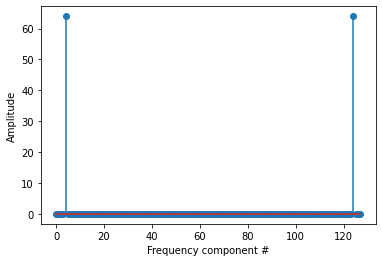

In [15]:
plt.figure()
plt.stem(np.abs(FL))
plt.xlabel("Frequency component #")
plt.ylabel("Amplitude")
plt.show()

We see two peaks, which means two _frequency components_
have a high(est) amplitude.
Let's find out what the first of these is:

In [16]:
peak_frequency_idx = np.argmax(amplitude_spectrum)
print(f"Maximum amplitude is for frequency component with index {peak_frequency_idx}")

Maximum amplitude is for frequency component with index 4


Okay, what does that mean? What frequency does that correspond to?

To figure this out, we can use the `fftfreq()` function,
which gives a vector of the frequencies extracted
for given a number of samples and the sampling interval
(sampling interval, i.e., the interval between samples,
 can be calculated as unit-time divided by sampling rate,
 i.e., the inverse of sampling rate)

In [17]:
freqs = scipy.fft.fftfreq(len(times), d=(1/sampling_rate))
print(freqs)

[  0.     0.25   0.5    0.75   1.     1.25   1.5    1.75   2.     2.25
   2.5    2.75   3.     3.25   3.5    3.75   4.     4.25   4.5    4.75
   5.     5.25   5.5    5.75   6.     6.25   6.5    6.75   7.     7.25
   7.5    7.75   8.     8.25   8.5    8.75   9.     9.25   9.5    9.75
  10.    10.25  10.5   10.75  11.    11.25  11.5   11.75  12.    12.25
  12.5   12.75  13.    13.25  13.5   13.75  14.    14.25  14.5   14.75
  15.    15.25  15.5   15.75 -16.   -15.75 -15.5  -15.25 -15.   -14.75
 -14.5  -14.25 -14.   -13.75 -13.5  -13.25 -13.   -12.75 -12.5  -12.25
 -12.   -11.75 -11.5  -11.25 -11.   -10.75 -10.5  -10.25 -10.    -9.75
  -9.5   -9.25  -9.    -8.75  -8.5   -8.25  -8.    -7.75  -7.5   -7.25
  -7.    -6.75  -6.5   -6.25  -6.    -5.75  -5.5   -5.25  -5.    -4.75
  -4.5   -4.25  -4.    -3.75  -3.5   -3.25  -3.    -2.75  -2.5   -2.25
  -2.    -1.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25]


These frequencies are expressed in cycles per unit
-- per unit-time in our case, i.e. cycles-per-second (fps), or Hz.

In [18]:
peak_frequency = freqs[np.argmax(amplitude_spectrum)]
print(f"The maximum amplitude in our signal is for frequency {peak_frequency:.1f} Hz")

assert peak_frequency == original_frequency

The maximum amplitude in our signal is for frequency 1.0 Hz


This matches the frequency we put in at the top!
So, we have succesfully recovered the frequency of our signal.

But there were two peaks in the amplitude spectrum? What's that about...
Well, if we now plot the amplitude spectrum with the actual frequencies,
we can see what's going on:

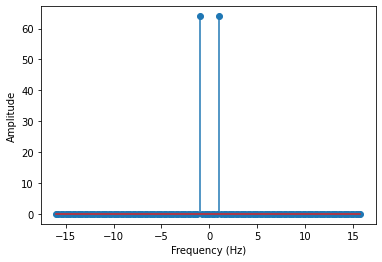

In [19]:
plt.figure()
plt.stem(freqs, amplitude_spectrum)
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.show()

The Fourier transform extracts both positive and _negative_ frequencies.
While in the real world negative frequencies don't make a lot of sense,
mathematically they're just as valid as positive frequencies.
Thus, the Fourier transform needs to return both of these
to give a full mathematical transformation of the signal into the frequency domain.

In our cases, the positive and negative frequencies
will always be mirror symmetric around the origin ($0$).
We can see that our other peak is at the negative of the frequency that we put in.

You could plot just the positive frequencies,
but convention is mostly to plot both.

Let's look at the amplitude of our signal.
Since we're looking at an amplitude spectrum,
the height (y-value) of our peak should be the amplitude of our original signal, right?

In [20]:
print(f"Recovered amplitude = {np.max(amplitude_spectrum):.1f} (original = {original_amplitude:.1f})")

Recovered amplitude = 64.0 (original = 1.0)


This doesn't match. Instead, the recovered amplitude is `2*sampling_rate` times higher...

The amplitude of each frequency component in the Fourier transform,
is the amplitude _per unit time_,
i.e. the integrated (summed) amplitude over the number of samples in 1 second,
(which is the sampling rate).

The amplitude that we defined earlier, is the _peak_ amplitude,
i.e., the maximum deviation from 0 that the signal will take each period.

For sinusoidal signals, the integrated amplitude per unit time,
is the peak amplitude times the sampling rate.
Conversely, for the sinusoidal frequency components represented in an amplitude spectrum,
we can get the peak amplitude by dividing the amplitude spectrum by the sampling rate:

In [21]:
peak_amplitudes = amplitude_spectrum / (2*sampling_rate)
display(peak_amplitudes)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0.])

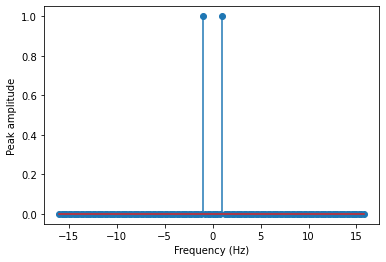

In [22]:
plt.figure()
plt.stem(freqs, peak_amplitudes)
plt.ylabel("Peak amplitude")
plt.xlabel("Frequency (Hz)")
plt.show()

This makes sense now:
we see the peak amplitude with which we created our original signal,
at the frequency of our sinusoid
(and at its negative complement)

### How signal parameters show up in the frequency domain
Let's look at some variations of our signal
and what those look like in the frequency domain.

Use the widget to change the frequency and amplitude
of the signal.

How do you expect the amplitude spectrum to change?
Does it match your expectations?

In [23]:
def plot_sinusoids(frequency=1, amplitude=1, phase=0, mean=0):
    # Generate sinusoid
    s = sinusoid(frequency=frequency, amplitude=amplitude, phase=phase, times=times, mean=mean)
    
    # Transform
    freqs = scipy.fft.fftfreq(len(times), d=(1/sampling_rate))
    Fs = scipy.fft.fft(s)
    amplitude_spectrum = np.abs(Fs)
    peak_amplitudes = amplitude_spectrum / (2*sampling_rate)
    
    # Plot
    fig, (ax_wav, ax_amp) = plt.subplots(1,2)
    ax_wav.plot(times, L, "k:", label="original")
    ax_wav.set_ylim(-2,2)
    ax_wav.plot(times, s)
    ax_wav.set_xlabel("Time (s)")
    
    ax_amp.stem(freqs, peak_amplitudes)
    ax_amp.set_ylim(0,2)
    ax_amp.axvline(original_frequency, linestyle=":", color="k")
    ax_amp.axvline(-original_frequency, linestyle=":", color="k")
    ax_amp.set_ylabel("Peak amplitude")
    ax_amp.yaxis.tick_right()
    ax_amp.yaxis.set_label_position("right")
    ax_amp.set_xlabel("Frequency (Hz)")
    
interactive_plot = widgets.interactive(plot_sinusoids, frequency=(0, sampling_rate/2, 8/sampling_rate), amplitude=(0, 2, 0.1), phase=(0,2*np.pi), mean=(-1,1,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='frequency', max=16.0, step=0.25), FloatSlider(value=…

You should observe a few things in the amplitude spectrum:
- Changing the frequency of the input signal changes where the peak in the amplitude spectrum is. Increasing the frequency moves the peak to the right (and the negative frequency peak to the left, i.e., pushes them apart).
- Changing the amplitude of the singal changes the height of the peak.
- Changing the phase does not change the amplitude spectrum.
- Changing the mean of the signal, changes the amplitude of the component at 0 Hz

#### 0 Hz frequency
The component at 0 Hz is often called the _direct current_ or _DC_ component.
It's the remaining "signal" when there is no oscillation;
it's the total integrated sum of the signal over the whole period;
for a symmetric signal like a sinusoid, it is thus also the mean.

Remember: in our example of a flashing light,
the mean of that signal (the flashing) is the background/pedestal on which the flashing occurs.
If we set our mean $=0$,
then the contrast is modulated around the background luminance;
if the the mean $\neq0$, then the contrast is modulated around some pedestal luminance.

### Phase
Phase does not show up in the amplitude spectrum.
As mentioned above, the complex-valued output of the Fourier transform
captures the amplitude as the magnitude of the complex number,
and the phase as the _angle_ of the complex number.

In [24]:
phases = np.angle(FL)

In [25]:
print(f"Peak frequency component has phase {phases[np.argmax(peak_amplitudes)]:.2f} degrees (original = {original_phase})")

Peak frequency component has phase 1.00 degrees (original = 1)


In [26]:
def plot_sinusoids(frequency=1, amplitude=1, phase=0, mean=0):
    # Generate sinusoid
    s = sinusoid(frequency=frequency, amplitude=amplitude, phase=phase, times=times, mean=mean)
    
    # Transform
    freqs = scipy.fft.fftfreq(len(times), d=(1/sampling_rate))
    Fs = scipy.fft.fft(s)
    phases = np.angle(Fs)
    amplitude_spectrum = np.abs(Fs)
    phases[amplitude_spectrum < 1] = 0
    
    # Plot
    fig, (ax_wav, ax_phase) = plt.subplots(1,2)
    ax_wav.plot(times, L, "k:", label="original")
    ax_wav.set_ylim(-2,2)
    ax_wav.plot(times, s)
    ax_wav.set_xlabel("Time (s)")
    
    ax_phase.stem(freqs, phases)
    ax_phase.set_ylim(-np.pi,np.pi)
    ax_phase.set_ylabel("Phase (radians)")
    ax_phase.yaxis.tick_right()
    ax_phase.yaxis.set_label_position("right")
    ax_phase.set_xlabel("Frequency (Hz)")
    
interactive_plot = widgets.interactive(plot_sinusoids, frequency=(0, sampling_rate/2, 8/sampling_rate), amplitude=(0, 2, 0.1), phase=(0,2*np.pi), mean=(-1,1,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='frequency', max=16.0, step=0.25), FloatSlider(value=…

### DFT resolution

The accuracy or _resolution_ of the discrete Fourier transform (DFT)
is limited by the number of samples per unit time (the sampling rate) that we have:
if our signal would go from $[-\infty, +\infty]$,
the resolution of the DFT would be infinitely accurate.

Moreover, the _accuracy_ of the recovered frequency, amplitude and phase
depend on the number of samples we have
in relation to the frequency of the signal.

- To get 0 spread in amplitude and phase spectrum,
the signal frequency has to be an integer multiple
of the DFT fundamental frequency,
such that an integer number of periods fit into the duration.

In [27]:
# TODO: widget to play with sampling rate.

### Power spectrum
The _power spectrum_ is defined as the square of the amplitude spectrum:
$$ power = amplitude^2 $$

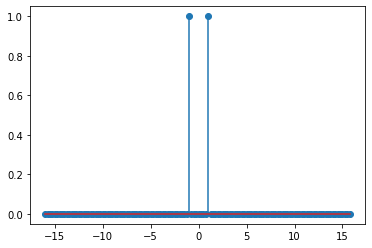

In [28]:
power_spectrum = peak_amplitudes ** 2

plt.figure()
plt.stem(freqs, power_spectrum)
plt.show()

## Compound waveforms:

### Multiplying == adding the same waveform
To change the amplitude of our original sinewave $s(t)$ (with unit ($1$) amplitude),
we have just been multiplying this sinewave:
$$ amplitude \cdot s(t) $$

Since multiplication is just repeatedly summing copies,
this is the same as 
$$ \sum^{amplitude} s(t) = s(t) + s(t) ... + s(t) $$

In [29]:
# Produce sinusoidal luminance (L) signal
L_unit = sinusoid(frequency=original_frequency, amplitude=original_amplitude, phase=original_phase, times=times)
L_scaled = sinusoid(frequency=original_frequency, amplitude=2*original_amplitude, phase=original_phase, times=times)
L_summed = L_unit+L_unit

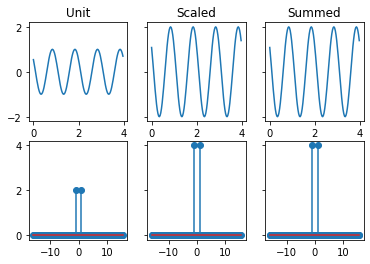

In [30]:
# Transform
freqs = scipy.fft.fftfreq(len(times), d=(1/sampling_rate))
FL_unit = scipy.fft.fft(L_unit)
FL_scaled = scipy.fft.fft(L_scaled)
FL_summed = scipy.fft.fft(L_summed)
peak_amps_unit = np.abs(FL_unit) / sampling_rate
peak_amps_scaled = np.abs(FL_scaled) / sampling_rate
peak_amps_summed = np.abs(FL_summed) / sampling_rate

# Plot
plt.close()
fig, axs = plt.subplots(2,3, sharey='row', sharex="row")

axs[0, 0].plot(times, L_unit, label="unit")
axs[0, 0].set_title("Unit")
axs[0,1].plot(times, L_scaled, label="scaled")
axs[0, 1].set_title("Scaled")
axs[0,2].plot(times, L_summed, label="summed")
axs[0, 2].set_title("Summed")

axs[1,0].stem(freqs, peak_amps_unit, label="unit")
axs[1,1].stem(freqs, peak_amps_scaled, label="scaled")
axs[1,2].stem(freqs, peak_amps_summed, label="summed")

plt.show()

We can see that this addition works in the time-domain,
and that the peak frequency domain reflects the summed amplitude as well.

### Adding different sinusoids
But what happens if we add two sinusoids with _different_ frequencies (and different amplitudes)?

Here we have our original sinusoid,
and you can select the parameters of a second sinusoid.
These two then get summed into a compound waveform,
and the amplitude spectra of this compoud waveform
and the two components are plot.

In [31]:
def plot_compounds(frequency=1, amplitude=1, phase=0, mean=0):
    # Generate sinusoid
    L_1 = sinusoid(frequency=original_frequency, amplitude=original_amplitude, phase=original_phase, times=times, mean=0)
    L_2 = sinusoid(frequency=frequency, amplitude=amplitude, phase=phase, mean=mean, times=times)
    L_summed = L_1 + L_2    
    
    # Transform
    freqs = scipy.fft.fftfreq(len(times), d=(1/sampling_rate))
    FL_1 = scipy.fft.fft(L_1)
    FL_2 = scipy.fft.fft(L_2)
    FL_summed = scipy.fft.fft(L_summed)
    peak_amps_1 = np.abs(FL_1) / (2*sampling_rate)
    peak_amps_2 = np.abs(FL_2) / (2*sampling_rate)
    peak_amps_summed = np.abs(FL_summed) / (2*sampling_rate)
    
    # Plot
    plt.close()
    fig, axs = plt.subplots(2,3, sharey='row', sharex="row")
    axs[0, 0].plot(times, L_1, label=f"{original_frequency} Hz")
    axs[0, 0].set_title(f"{original_frequency} Hz")
    axs[0,1].plot(times, L_2, label=f"{frequency} Hz")
    axs[0, 1].set_title(f"{frequency} Hz")
    axs[0,2].plot(times, L_summed, label="summed")
    axs[0, 2].set_title("Summed")
    axs[0, 1].set_xlabel("Time (s)")
    axs[0, 0].set_ylim(-4,4)

    
    axs[1,0].stem(freqs, peak_amps_1, label=f"{original_frequency} Hz")
    axs[1,1].stem(freqs, peak_amps_2, label=f"{frequency} Hz")
    axs[1,2].stem(freqs, peak_amps_summed, label="summed")   
    axs[1,0].set_ylabel("Peak amplitude")
    axs[1,1].set_xlabel("Frequency (Hz)")
    axs[1,0].set_ylim(0,3)

    
interactive_plot = widgets.interactive(plot_compounds, frequency=(0, sampling_rate/2, 8/sampling_rate), amplitude=(0, 2, 0.1), phase=(0,2*np.pi), mean=(-1,1,0.1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='frequency', max=16.0, step=0.25), FloatSlider(value=…

We can see that the combined waveform is a perfection composition of the two components.
The amplitude spectrum also reflects this:
it contains both the original frequency and its amplitude,
and the second component at its amplitude.

Hopefully you already observe (depending on the parameters you chose)
that compound waveforms can be surprisingly hard to identify.
Here there are just two sinusoidal components,
but the compound can already seem erratic. The Fourier transform can take this hard to identify pattern,
and because it breaks it down into constinuent components,
reveal the simpler underlying structure.

**This is the goal of spectral analysis: by using an alternative representation of the signal, provide insights into its structure**

### Squarewave

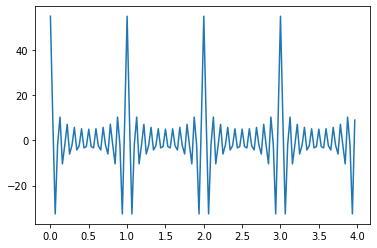

In [32]:
# TODO
n_components = 10
f_components = np.arange(n_components) + 1
a_components = np.arange(n_components) + 1

components = np.zeros((n_components, len(times)))
for i, (f,a) in enumerate(zip(f_components, a_components)):
    component = sinusoid(frequency=f, amplitude=a, times=times)
    components[i,:] = component

plt.close()
plt.figure()
plt.plot(times, components.sum(axis=0))
plt.show()

### Signal in "noise"
Since frequency analysis can reveal some underlying structure
in a signal that looks erratic,
it is especially useful for problems where there is a signal "hidden" in nosie.

Here, we add pseudorandom Gaussian noise to each sample of our singal.
In the time domain, the waveform indeed looks random;
it's hard to identify the original signal.

However, in the amplitude spectrum we can clearly see
the peak frequency stand out.
This frequency-domain representation of our signal
allows us to identify the signal easily.


The spectrum also shows a key property of random noise:
it is composed of all frequency components, with various amplitudes
(it "contains power at all frequencies").
True "white noise",
where each sample is completely independent from all other samples
will have uniform power at all frequencies.

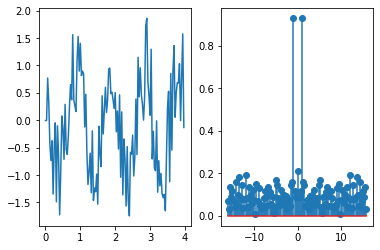

In [33]:
from numpy.random import default_rng
rng = default_rng(12345)

#L_2 = L + rng.normal(loc=0, scale=1, size=len(L))
L_2 = L + rng.uniform(-1,1,size=len(L))

Fy = scipy.fft.fft(L_2)
amplitude_spectrum = np.abs(Fy) / (2*sampling_rate)

plt.subplot(1,2,1)
plt.plot(times, L_2)
plt.subplot(1,2,2)
plt.stem(freqs, amplitude_spectrum)
plt.show()

## Filtering

## Spatial frequency (1D)

### Stack frames to become image
Imagine that rather than playing all the frames of our flickering light animation
one after the other
and instead took (some of) these frames and placed them next to each other:

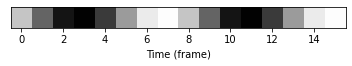

In [167]:
idc = np.arange(0, 2*sampling_rate, step=sampling_rate/8).astype(int)

fig, ax = plt.subplots()
ax.imshow(L[idc] * np.ones((1,len(idc))), cmap="gray", vmin=-1, vmax=1)
ax.set_aspect(1)
ax.yaxis.set_visible(False)
ax.set_xlabel("Time (frame)")
plt.show()

Since the pattern across frames is the same
as when we played it as animation,
we can still describe these frames as a sinusoidal signal --
see how the (relative) intensity in each frame is still indicated
by the height of the waveform:

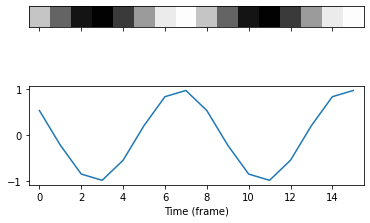

In [83]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex="all")
ax1.imshow(L[idc] * np.ones((1,len(idc))), cmap="gray", vmin=-1, vmax=1)
ax1.set_aspect(1)
ax1.yaxis.set_visible(False)

ax2.plot(L[idc])
ax2.set_xlabel("Time (frame)")
plt.show()

Now let's take all our frames and put them side-by-side this way.
It will be a lot frames, and the intensity change from one to another is small
so you won't be able to really see the border between one frame and its neighbor anymore.

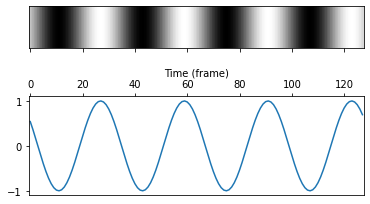

In [116]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex="all")
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1)
ax1.set_aspect(16)
ax1.yaxis.set_visible(False)
ax1.xaxis.tick_bottom()

ax2.plot(L)
ax2.set_xlabel("Time (frame)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
plt.show()

The signal is still perfectly described by the waveform
-- but now it instead of flickering light, it looks like a grating!
Instead of changing contrast over _time_ (flickering),
is represented such that contrast changes over _space_.

How should we think about this?

Let's remind ourselves of some aspects of our signal:

In [170]:
print(f"Frequency is {original_frequency} cycle(s) per second")
print(f"Duration is {duration} second(s), sampled with {sampling_rate*duration} frames (= at {sampling_rate} fps)")
print(f"{original_frequency * duration} cycle(s) total, in {sampling_rate*duration} frames total")

Frequency is 1 cycle(s) per second
Duration is 4 second(s), sampled with 128 frames (= at 32 fps)
4 cycle(s) total, in 128 frames total


Well, _we_ decided each sample represents a temporal frame.
We can also decided that each sample represents a pixel:

In [171]:
print(f"{sampling_rate*duration} frames becomes {sampling_rate*duration} pixels")
print(f"{original_frequency * duration} cycle(s) total stays {original_frequency * duration} cycle(s) total")

128 frames becomes 128 pixels
4 cycle(s) total stays 4 cycle(s) total


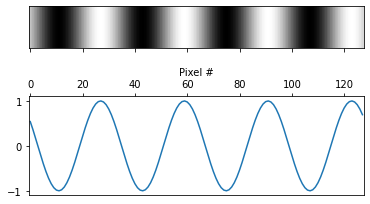

In [172]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex="all")
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1)
ax1.set_aspect(16)
ax1.yaxis.set_visible(False)

ax2.plot(L)
ax2.set_xlabel("Pixel #")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
plt.show()

### Spatial frequency: cycles per image; cycles per degree

The least simple of this, is how to express the now _spatial_ frequency.
We can of course just express the total number of _cycles per image_:

In [173]:
print(f"{original_frequency * duration} cycle(s) per image")

4 cycle(s) per image


but that would be akin to expressing the temporal frequency as "cycles per X total seconds".
Instead, we should use a physical unit for space. We could use cm, inches, etc.

In vision science, the logical choice is _degrees of visual angle_.
As a result, our unit of frequency becomes _cycles per degree of visual angle_, or _cpd_ for short.

Similarly, the sampling rate is now not _frames per second_,
but _pixels per degree of visual angle_, or _ppd_ for short.

In [176]:
print(f"Frequency is {original_frequency} cycle(s) per degree")
print(f"Visual extent is {duration} degree(s), sampled with {sampling_rate*duration} pixels (= at {sampling_rate} ppd)")
print(f"{original_frequency * duration} cycle(s) total, in {sampling_rate*duration} pixels (= pixels per image)")

Frequency is 1 cycle(s) per degree
Visual extent is 4 degree(s), sampled with 128 pixels (= at 32 ppd)
4 cycle(s) total, in 128 pixels (= pixels per image)


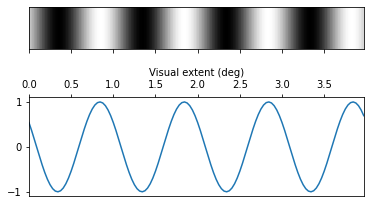

In [177]:
x = times
visextent = (np.min(x), np.max(x), -1/(sampling_rate*8), 1/(sampling_rate*8))


fig, (ax1, ax2) = plt.subplots(2,1, sharex="all")
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=visextent)
ax1.set_aspect(2*sampling_rate)
ax1.yaxis.set_visible(False)

ax2.plot(x, L)
ax2.set_xlabel("Visual extent (deg)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
plt.show()

...or if we center the image on $(0,0)$ degrees...

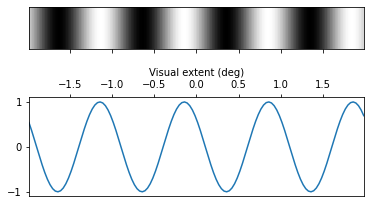

In [165]:
x = times - np.max(times)/2
visextent = (np.min(x), np.max(x), -1/(sampling_rate*8), 1/(sampling_rate*8))


fig, (ax1, ax2) = plt.subplots(2,1, sharex="all")
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=visextent)
ax1.set_aspect(2*sampling_rate)
ax1.yaxis.set_visible(False)

ax2.plot(x, L)
ax2.set_xlabel("Visual extent (deg)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
plt.show()

The nice thing is that the Fourier transform does not care about any of these units,
or even whether your signal is in time or space!

We can take the exact same Fourier transform of our signal and plot the spectrum;
the only thing we need to change is the axis labels.

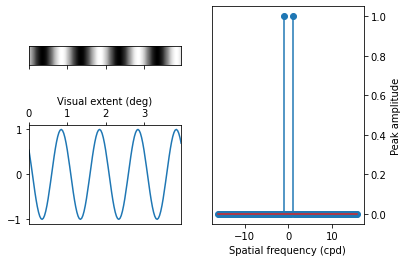

In [180]:
FL = scipy.fft.fft(L)
freqs = scipy.fft.fftfreq(len(L), d=(1/sampling_rate))
amplitude_spectrum = np.abs(FL)
peak_amplitudes = amplitude_spectrum / (2*sampling_rate)

fig, axs = plt.subplots(2,2, sharex="col")

ax1 = axs[0,0]
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=visextent)
ax1.set_aspect(2*sampling_rate)
ax1.yaxis.set_visible(False)

ax2 = axs[1,0]
ax2.plot(x, L)
ax2.set_xlabel("Visual extent (deg)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")

amps = plt.subplot(1,2,2)
amps.stem(freqs, peak_amplitudes)
amps.yaxis.tick_right()
amps.yaxis.set_label_position("right")
amps.set_ylabel("Peak amplitude")
amps.set_xlabel("Spatial frequency (cpd)")


plt.show()

**Spatial frequency (as compared to temporal frequency) is not else than a relabeling of axes and units!**

### Another example: Gaussian

### "Gabor"